4.1 Base Clustering

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

def cluster_kmeans_base(corr:pd.DataFrame, max_num_clusters=10, n_init=10):
    '''
    n_init을 여러번 하고 최대 max_num_clusters만큼 cluster를 만들어보면서 k-mean의 initialization 문제를 최소화하고 최적의 cluster 개수를 선정하여 결과를 반환하는 함수
    '''
    x=np.sqrt(0.5*(1-corr.fillna(0))) # distance of features

    best_cluster_quality=None
    best_sil=None
    best_kmeans=None
    for _ in range(n_init): # multi initialization
        for i in range(2, max_num_clusters+1):
            kmeans=KMeans(n_clusters=i, n_init=1).fit(x)
            sil=silhouette_samples(x, kmeans.labels_)
            cluster_quality=sil.mean()/sil.std() # cluster score
            if best_cluster_quality is None or best_cluster_quality<cluster_quality:
                best_cluster_quality=cluster_quality
                best_sil=pd.Series(sil, index=x.index)
                best_kmeans=kmeans

    sorted_idx=np.argsort(best_kmeans.labels_)
    ret_corr=corr.iloc[sorted_idx] # reorder rows by cluster result
    ret_corr=corr.iloc[:, sorted_idx] # reorder columns by cluster result

    cluster_dict={i:corr.columns[np.where(best_kmeans.labels_==i)[0].tolist()] for i in np.unique(best_kmeans.labels_)}
    return ret_corr, cluster_dict, best_sil


4.2 Top-Level of Clustering

In [3]:
def cluster_kmeans_top(corr:pd.DataFrame, max_num_clusters=None, n_init=10):
    '''
    cluster_kmeans_base에 더하여 cluster마다 결과가 좋지 못했던 cluster만 모아서 재학습을 시켜 전반적인 cluster quality를 올리는 알고리즘
    '''
    def override_cluster_result(corr:pd.DataFrame, cluster_dict_ori:dict, cluster_dict_new:dict):
        new_cluster_dict_ret={}
        for label in cluster_dict_ori.keys():
            new_cluster_dict_ret[len(new_cluster_dict_ret)]=list(cluster_dict_ori[label])
        for label in cluster_dict_new.keys():
            new_cluster_dict_ret[len(new_cluster_dict_ret)]=list(cluster_dict_new[label]) # override

        # reindex correlation matrix
        new_idx=[idx for i in new_cluster_dict_ret.keys() for idx in new_cluster_dict_ret[i]]
        corr_new=corr.loc[new_idx, new_idx]

        # recalculate sil score
        x=np.sqrt(0.5*(1-corr.fillna(0))) # distance of features
        kmeans_lables=np.zeros(len(x.columns))
        for i in new_cluster_dict_ret.keys():
            cur_idx=[x.index.get_loc(k) for k in new_cluster_dict_ret[i]]
            kmeans_lables[cur_idx]=i
        sil_new=pd.Series(silhouette_samples(x.values, kmeans_lables), index=x.index)
        return corr_new, new_cluster_dict_ret, sil_new
    if max_num_clusters is None: max_num_clusters=corr.shape[0]-1

    ret_corr, cluster_dict, best_sil=cluster_kmeans_base(corr, max_num_clusters, n_init)

    cluster_quality_dict={
        label:np.mean(best_sil[cluster_dict[label]])/np.std(best_sil[cluster_dict[label]])     
        if np.std(best_sil[cluster_dict[label]]) != 0 else 0
        for label in cluster_dict.keys()
    }

    mean_cluter_quality=np.sum(list(cluster_quality_dict.values()))/len(cluster_quality_dict)

    bad_cluster_labels=[label for label in cluster_quality_dict.keys() if cluster_quality_dict[label]<mean_cluter_quality]

    if len(bad_cluster_labels)<=1:
        return ret_corr, cluster_dict, best_sil
    else:
        bad_cluster_data_index=[data_index for label in bad_cluster_labels for data_index in cluster_dict[label]]
        bad_data_corr=corr.loc[bad_cluster_data_index, bad_cluster_data_index]
        mean_bad_cluster_quality=np.mean([cluster_quality_dict[label] for label in bad_cluster_labels])

        recluster_corr, recluster_cluster_dict, recluster_sil=cluster_kmeans_top(bad_data_corr, min(max_num_clusters, bad_data_corr.shape[0]-1), n_init)

        # remake new output
        corr_new, cluster_dict_new, silh_new=override_cluster_result(corr, {label:cluster_dict[label] for label in cluster_dict.keys() if label not in bad_cluster_labels}, recluster_cluster_dict)

        mean_new_cluster_quality = np.mean([
            np.mean(silh_new[cluster_dict_new[label]]) / std
            if (std := np.std(silh_new[cluster_dict_new[label]])) != 0 else 0
            for label in cluster_dict_new.keys()
        ])

        if mean_new_cluster_quality<=mean_bad_cluster_quality: # cluster 개선 X
            return ret_corr, cluster_dict, best_sil
        else: # cluster 개선 O
            return corr_new, cluster_dict_new, silh_new


4.3 Random Block Correlation Matrix Creation

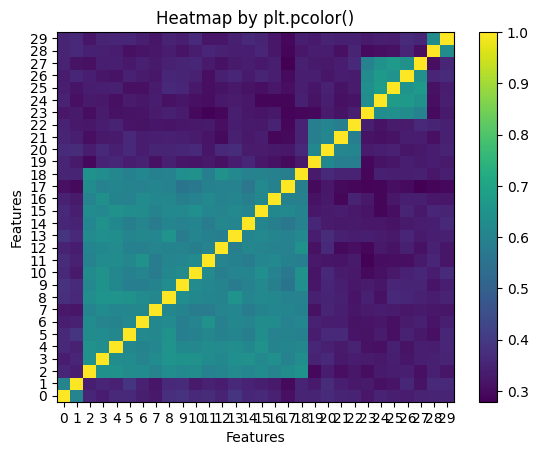

In [4]:
from scipy.linalg import block_diag
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt


def get_random_block_cov(n_cols:int, n_blocks:int, sigma=0.1, min_block_size=1, random_state=None):
    rng=check_random_state(random_state)

    sizes=rng.choice(range(1, n_cols-(min_block_size-1)*n_blocks), n_blocks-1, replace=False)
    sizes.sort()
    sizes=np.append(sizes, n_cols-(min_block_size-1)*n_blocks)
    sizes=np.append(sizes[0], np.diff(sizes))+min_block_size-1

    def get_block_cov(n_obs:int, n_cols:int, sigma:float, random_state=None):
        rng=check_random_state(random_state)
        if n_cols==1: return np.ones((n_cols, n_cols))
        col=rng.normal(size=(n_obs, 1))
        matrix=np.repeat(col, n_cols, axis=1)
        matrix+=rng.normal(scale=sigma, size=matrix.shape)
        cov=np.cov(matrix, rowvar=False)
        return cov

    ret=None
    for s in sizes:
        n_obs=int(max(s*(s+1)/2, 100))
        cov=get_block_cov(n_obs, s, sigma, random_state)
        if ret is None: ret=cov
        else: ret=block_diag(ret, cov)
    return ret


def get_random_block_corr(n_cols:int, n_blocks:int, sigma_s:float, sigma_b:float, min_block_size=1, random_state=None):
    rng=check_random_state(random_state)

    cov_s=get_random_block_cov(n_cols, n_blocks, sigma_s, min_block_size, rng)
    cov_b=get_random_block_cov(n_cols, 1, sigma_b, min_block_size, rng)

    def get_corr_matrix(cov:pd.DataFrame):
        std=np.sqrt(np.diag(cov))
        corr=cov/np.outer(std, std)
        np.clip(corr, -1.0, 1.0, out=corr)
        return corr

    ret_cov=cov_s+cov_b
    ret_corr=get_corr_matrix(ret_cov)
    labels=[f"{i}" for i in range(n_cols)]
    ret_corr=pd.DataFrame(ret_corr, index=labels, columns=labels)
    return ret_corr


block_corr=get_random_block_corr(30, 5, 0.5, 1, 2)
plt.pcolor(block_corr)
plt.xticks(np.arange(0.5, len(block_corr.columns), 1), block_corr.columns)
plt.yticks(np.arange(0.5, len(block_corr.index), 1), block_corr.index)
plt.title('Heatmap by plt.pcolor()', fontsize=12)
plt.xlabel('Features')
plt.ylabel('Features')
plt.colorbar()

plt.show()


4.5 Experimental Results

In [5]:
from collections import defaultdict

trial_counts=30
trial_ret=defaultdict(list)
for n_cols in [20, 40, 80, 160]:
    for n_blocks in range(5, int(n_cols/2), 5):
        key=np.round(n_blocks/n_cols, 2)
        correct_cnt=0
        for _ in range(trial_counts):
            corr=get_random_block_corr(n_cols, n_blocks, 0.5, 1, min_block_size=2)
            corr_new, cluster_dict, sil=cluster_kmeans_top(corr)
            if len(cluster_dict)==n_blocks:
                correct_cnt+=1
        correct_ratio=float(correct_cnt/trial_counts)
        trial_ret[key].append(correct_ratio)
        
        


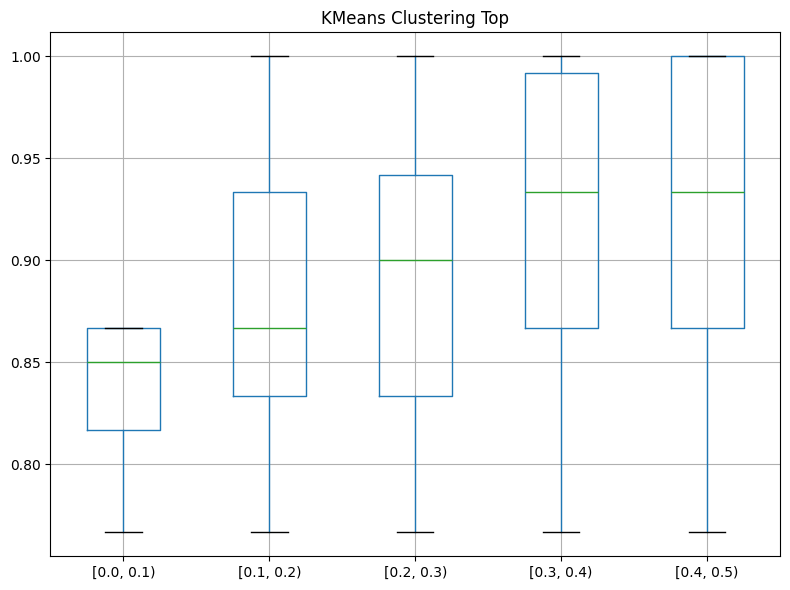

In [ ]:
data_dict = {}
for decile in np.arange(0.1, 0.6, 0.1):
    cur_data = []
    for k, v in trial_ret.items():
        if k < float(decile):
            cur_data.extend(v)
    data_dict[decile] = cur_data

decile_df = pd.DataFrame(dict([(f"[{k-0.1:.1f}, {k:.1f})", pd.Series(v)) for k, v in data_dict.items()]))

fig, ax = plt.subplots(figsize=(8, 6))
decile_df.boxplot(ax=ax)
ax.set_title("KMeans Clustering Top")

plt.tight_layout()
plt.show()
